In [1]:
from collections import OrderedDict
import json
import random
import os

In [2]:

def read_data(data_file):

    arg_type_map = OrderedDict({
        "subject disorder": "subject_disorder",
        "time elapsed":"time_elapsed",
        "treatment disorder":"indication",
        "combination drug":"combination_drug",
    })

    data = OrderedDict()

    with open(data_file, "r") as f:
        for line in f.readlines():
            sample = {}
            instance = json.loads(line)
            sample["id"] = instance["text_id"]
            sample["sentence"] = instance["text"]
            sample["event_types"] = []
            answer = []
            events = instance['event']
            for event in events:
                sample["event_types"].append(event["type"])
                evt = {
                    "event_type": event["type"],
                    "event_trigger": event["text"],
                    "arguments": OrderedDict({
                        "subject":[],
                        "treatment":[],
                        "effect":[],
                        "age":[],
                        "gender":[],
                        "race":[],
                        "population":[],
                        "subject_disorder":[],
                        "drug":[],
                        "dosage":[],
                        "route":[],
                        "duration":[],
                        "frequency":[],
                        "time_elapsed":[],
                        "indication":[],
                        "combination_drug":[]
                    })
                }

                for argument in event['args']:
                    arg_type = argument['type']
                    arg_type = arg_type_map[arg_type] if arg_type in arg_type_map else arg_type
                    arg_span = argument['text']
                    evt["arguments"][arg_type].append(arg_span)
                for arg_type in evt["arguments"]:
                    if not evt["arguments"][arg_type]:
                        evt["arguments"][arg_type] = "N/A"
                    else:
                        evt["arguments"][arg_type] = "; ".join(evt["arguments"][arg_type])
                answer.append(evt)

            sample["answer"] = json.dumps(answer)
            data[sample["id"]] = sample

    return data

In [13]:
train_file = "../data/converted_data/text2spotasoc/event/phee_2/train.json"
train_data = read_data(train_file)
syn_folder = "output_3_constrain_drug"

In [14]:
sample_id = random.sample(list(train_data.keys()), 1)[0]
# sample_id = '19531695_12'
train_case = train_data[sample_id]
# train_case.pop('id')
print("Train case: ")
print(train_case)
syn_file = os.path.join(syn_folder, sample_id+".json")
print("Synthesized case:")
with open(syn_file, 'r') as f:
    print(f.read())


Train case: 
{'id': '1849334_1', 'sentence': 'Muzolimine - induced severe neuromyeloencephalopathy : report of seven cases .', 'event_types': ['adverse event'], 'answer': '[{"event_type": "adverse event", "event_trigger": "induced", "arguments": {"subject": "N/A", "treatment": "Muzolimine", "effect": "neuromyeloencephalopathy", "age": "N/A", "gender": "N/A", "race": "N/A", "population": "N/A", "subject_disorder": "N/A", "drug": "N/A", "dosage": "Muzolimine", "route": "N/A", "duration": "N/A", "frequency": "N/A", "time_elapsed": "N/A", "indication": "N/A", "combination_drug": "N/A"}}]'}
Synthesized case:
{"sentence": "Pyridostigmine bromide - induced gastrointestinal distress: report of five cases.", "output": [{"event_type": "adverse event", "event_trigger": "induced", "arguments": {"subject": "N/A", "treatment": "pyridostigmine bromide", "effect": "gastrointestinal distress", "age": "N/A", "gender": "N/A", "race": "N/A", "population": "N/A", "subject_disorder": "N/A", "drug": "N/A", "

In [38]:
from collections import Counter

def train_data_distribution(train_data):
    drugs = []
    effects = []
    age = []
    route = []
    dosage = []
    indication = []
    for instance in train_data.values():
        for event in json.loads(instance['answer']):
            if event['arguments']['drug'].lower() != 'methotrexate':
                continue
            drugs.append(event['arguments']['drug'].lower())
            effects.append(event['arguments']['effect'].lower())
            age.append(event['arguments']['age'].lower())
            route.append(event['arguments']['route'].lower())
            dosage.append(event['arguments']['dosage'].lower())
            indication.append(event['arguments']['indication'].lower())

    drug_distrib = Counter(drugs)
    effect_distrib = Counter(effects)
    age_distrib = Counter(age)
    route_distrib = Counter(route)
    dosage_distrib = Counter(dosage)
    indication_distrib = Counter(indication)

    return drug_distrib, effect_distrib, age_distrib, route_distrib, dosage_distrib, indication_distrib

drug_distrib, effect_distrib, age_distrib, route_distrib, dosage_distrib, indication_distrib = train_data_distribution(train_data)
print("total drug number:", len(drug_distrib))
print("total effect number:",len(effect_distrib))
print("most common 50 drugs:", drug_distrib.most_common(50))
print("most common 50 effects:", effect_distrib.most_common(50))

print("total age number:",len(age_distrib))
print("most common 50 age:", age_distrib.most_common(50))

print("total route number:",len(route_distrib))
print("most common 50 route:", route_distrib.most_common(50))

print("total dosage number:",len(dosage_distrib))
print("most common 50 dosage:", dosage_distrib.most_common(50))

print("total indication number:",len(indication_distrib))
print("most common 50 indication:", indication_distrib.most_common(50))
    

total drug number: 1
total effect number: 49
most common 50 drugs: [('methotrexate', 56)]
most common 50 effects: [('papular eruption', 5), ('pneumonitis', 2), ('acute renal failure', 2), ('diffuse interstitial pulmonary fibrosis', 2), ('pleuropericarditis', 1), ('fatal acute encephalomyelitis', 1), ('cerebral edema and brainstem herniation', 1), ('varying degrees of neurotoxicity', 1), ('delayed stroke - like leukoencephalopathy', 1), ('severe back pain and urinary retention', 1), ('bilateral pulmonary infiltrates without evidence of peripheral blood eosinophilia', 1), ('systemic toxicity', 1), ('the development of lung cancer', 1), ('lymphoproliferative disorder', 1), ('posterior reversible encephalopathy syndrome', 1), ('a fatal rise in intracranial pressure', 1), ('bone marrow aplasia and severe skin rash', 1), ('presenting with status epilepticus', 1), ('malignant lymphoma', 1), ('nephropathy', 1), ('diffuse interstitial pulmonary fibrosis; bilateral pulmonary infiltrates', 1), ('

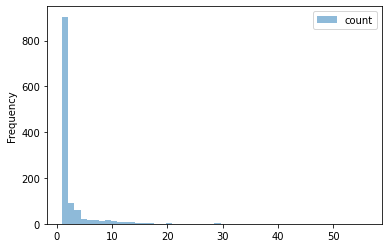

In [12]:
import pandas as pd
frame = []
for d in drug_distrib.most_common(len(drug_distrib)):
    out = {
        'item': d[0],
        'count': d[1]
    }
    frame.append(out)

frame = pd.DataFrame(frame)
frame.head()

import matplotlib.pyplot as plt

# frame.plot.scatter(x="pred_score", y="gold_score")
# plt.show()

ax = frame[['count']].plot.hist(bins=50, alpha=0.5)


In [44]:
# def syn_data_distribution():
#     drugs = []
#     for file_name in os.listdir(syn_folder):
#         with open(os.path.join(syn_folder, file_name), 'r') as f:
#             try:
#                 line = f.read()
#                 instance = json.loads(line)
#                 for event in instance["output"]:
#                     drugs.append(event["arguments"]["drug"].lower())
#             except:
#                 print(line)
#     distrib = Counter(drugs)
#     return distrib
syn_file = "../data/converted_data/text2spotasoc/event/phee_2_aug_constrain/train_aug_constrain_drug_and_effect.json"
syn_data = read_data(syn_file)
# drug_distrib, effect_distrib = train_data_distribution(syn_data)
# print("total drug number:", len(drug_distrib))
# print("total effect number:",len(effect_distrib))
# print("most common 50 drugs:", drug_distrib.most_common(50))
# print("most common 50 effects:", effect_distrib.most_common(50))
    
drug_distrib, effect_distrib, age_distrib, route_distrib, dosage_distrib, indication_distrib = train_data_distribution(syn_data)
print("total drug number:", len(drug_distrib))
print("total effect number:",len(effect_distrib))
print("most common 50 drugs:", drug_distrib.most_common(50))
print("most common 50 effects:", effect_distrib.most_common(50))

print("total age number:",len(age_distrib))
print("most common 50 age:", age_distrib.most_common(50))

print("total route number:",len(route_distrib))
print("most common 50 route:", route_distrib.most_common(50))

print("total dosage number:",len(dosage_distrib))
print("most common 50 dosage:", dosage_distrib.most_common(50))

print("total indication number:",len(indication_distrib))
print("most common 50 indication:", indication_distrib.most_common(50))

total drug number: 1
total effect number: 33
most common 50 drugs: [('methotrexate', 47)]
most common 50 effects: [('papular eruption', 4), ('systemic toxicity', 3), ('aseptic pleuropericarditis', 2), ('malignant lymphoma', 2), ('diffuse papular eruption', 2), ('lymphoproliferative disorder', 2), ('subacute neurotoxicity', 2), ('progressive interstitial fibrosis with roentgenographic honeycombing', 2), ('delayed stroke - like leukoencephalopathy', 2), ('serositis', 2), ('presenting with status epilepticus', 2), ('severe back pain and urinary retention', 1), ('bone marrow aplasia; severe skin rash', 1), ('involving an intracranial mass lesion and transtentorial herniation', 1), ('papular eruption in psoriasis', 1), ('severe mucositis', 1), ('acute renal failure', 1), ('diffuse pruritic papular eruption located mainly on the limbs', 1), ('leukoencephalopathy and hydrocephalus', 1), ('improved joint mobility', 1), ('neurotoxic effects', 1), ('sub - acute toxic leukoencephalopathy', 1), ("

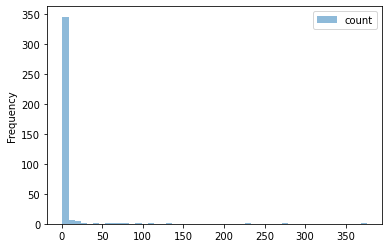

In [17]:
import pandas as pd
frame = []
for d in drug_distrib.most_common(len(drug_distrib)):
    out = {
        'item': d[0],
        'count': d[1]
    }
    frame.append(out)

frame = pd.DataFrame(frame)
frame.head()

import matplotlib.pyplot as plt

# frame.plot.scatter(x="pred_score", y="gold_score")
# plt.show()

ax = frame[['count']].plot.hist(bins=50, alpha=0.5)